In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install geopandas
!pip install rasterio
!pip install keras_spatial

In [22]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from keras_spatial import SpatialDataGenerator

In [35]:
dem_path = '/content/drive/My Drive/Image Segmentation/'
raster_dem = dem_path + 'Firsoff_HiRISE_5_low_res.tif-adj.tif'
sdg = SpatialDataGenerator(source=raster_dem)
print(sdg.src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 358, 'height': 632, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["Geographic Coordinate System",DATUM["D_MARS",SPHEROID["MARS",3396190,0]],PRIMEM["Reference Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(18.0, 0.0, -534141.0,
       0.0, -18.0, 135873.0)}


Created66 samples


,geometry
0,"POLYGON ((-533141.000 124497.000, -533141.000 ..."
1,"POLYGON ((-532052.200 124497.000, -532052.200 ..."
2,"POLYGON ((-530963.400 124497.000, -530963.400 ..."
3,"POLYGON ((-529874.600 124497.000, -529874.600 ..."
4,"POLYGON ((-528785.800 124497.000, -528785.800 ..."


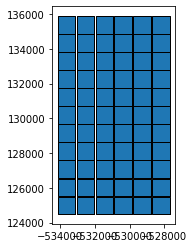

In [36]:
df = sdg.regular_grid(1000, 1000)

print(f'Created{len(df)} samples')
df.plot(color=None, edgecolor='k')
df.head()


Created 66 samples


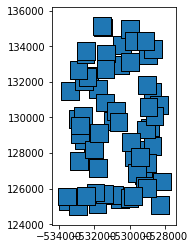

In [37]:
df_rand = sdg.random_grid(1000, 1000, 66)
print(f'Created {len(df_rand)} samples')
df_rand.plot(color=None, edgecolor='k')

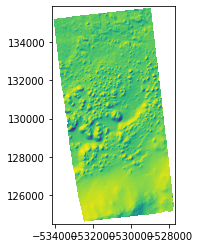

In [38]:
label_path = dem_path + 'Hillshade.tif'
dem = SpatialDataGenerator(source=label_path)
show(dem.src)

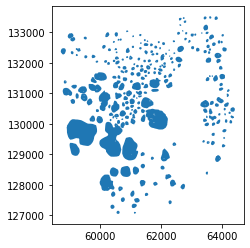

In [39]:
mounds_path = dem_path + 'polygons/mounds.shp'
mask = df = gpd.read_file(mounds_path) 
mask.plot()

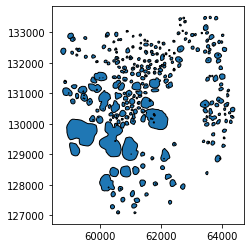

In [40]:
samples = df[df.intersects(mask.unary_union)].copy()
samples.plot(color=None, edgecolor='k')

,Morpho,orefice,geometry,features
0,simple,NO,"POLYGON ((60995.429 130809.061, 61008.451 1308...",-44604928.0
1,complex,YES,"POLYGON ((61663.849 130792.912, 61683.116 1307...",-203791408.0
2,vent,None,"POLYGON ((61644.427 130743.872, 61640.687 1307...",-2285215.5
3,simple,NO,"POLYGON ((60580.898 131576.003, 60584.554 1315...",-16614611.0
4,simple,YES,"POLYGON ((60816.684 131527.193, 60823.227 1315...",-26589624.0


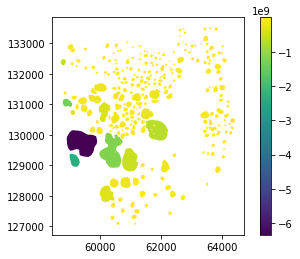

In [41]:
lsdg = SpatialDataGenerator(source=raster_dem)
width, height = 128, 128
samples['features'] =[(np.sum(np.where(arr==1, 0, arr) )) 
                    for arr in lsdg.flow_from_dataframe (samples, width, height, batch_size=1)]
samples.plot(column='features', legend=True) 
samples.head(5)

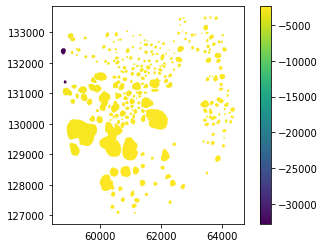

In [14]:
rsdg = SpatialDataGenerator(raster_dem)
samples['elevation'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (samples, 128, 128, batch_size=1)]
samples.plot(column='elevation', legend=True)

In [42]:
samples['maxelv'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (samples, 128, 128, batch_size=1)]
samples['minelv'] = [(np.min(np.where(arr>0, arr, np.nan))) for arr in rsdg.flow_from_dataframe (samples, 128, 128, batch_size=1)]
print(samples.maxelv.max(), samples.minelv.min())

-2412.250732421875 nan


In [47]:
def normalize(arr, gmin, gmax):
  return (arr - gmin) / (gmax - gmin)
sdg.add_preprocess_callback('elvnorm', normalize, samples.minelv.min(), samples.maxelv.max())
gen = sdg.flow_from_dataframe(samples, 128, 128, batch_size=1)
arr = next(gen)
imgplot = plt.imshow(arr[0, :, :, 0], cmap='viridis')
plt.colorbar()

ValueError: ignored

In [18]:
# example of Feeding samples to a DL model
width, height = 128, 128
train_gen = zip(labels.flow_from_dataframe(df, width, height), dem.flow_from_dataframe(df, width, height))